In [56]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictorS2S

from utils import normalize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 3
output_timesteps= 3

# Create a dataset using the modified MovingMNIST
MMMNIST = ModMovingMNIST(
    canvas_size=(32, 32),
    digit_size=(16, 16),
    pixel_noise=0.05,
    velocity_noise=0.0,
)

# Create a train set (500), test set (50), and validation set (50)
x, y = MMMNIST.create_dataset(250, input_timesteps, output_timesteps, n_digits=1)
x_test, y_test = MMMNIST.create_dataset(50, input_timesteps, output_timesteps, n_digits=1)
x_val, y_val = MMMNIST.create_dataset(50, input_timesteps, output_timesteps, n_digits=1)

# y, y_test, y_val = y[:, ::-1].copy(), y_test[:, ::-1].copy(), y_val[:, ::-1].copy()

# x, y = normalize(x), normalize(y)
# x_test, y_test = normalize(x_test), normalize(y_test)
# x_val, y_val = normalize(x), normalize(y)

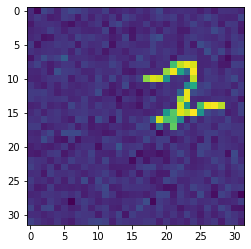

In [15]:
plt.imshow(x[0, 0])

In [58]:
from mpnnlstm import NextFramePredictor
from seq2seq import Seq2Seq

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
nn = Seq2Seq(
    hidden_size=64,
    dropout=0.1,
    input_features=1+3,
    output_timesteps=output_timesteps,
    n_layers=3).float()


model = NextFramePredictorS2S(
    nn,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=device,
    output_timesteps=output_timesteps)

model.get_n_params()

172353

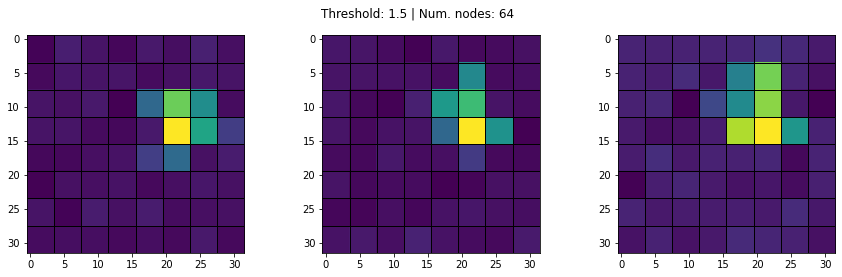

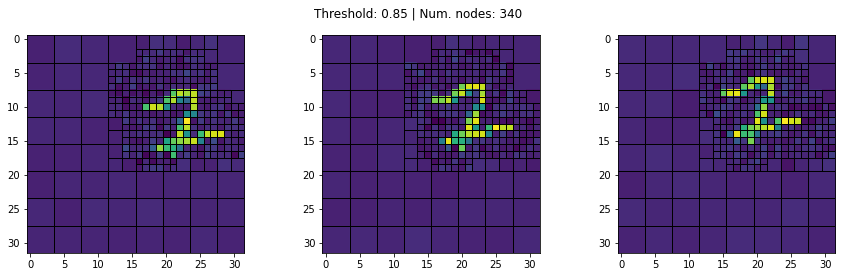

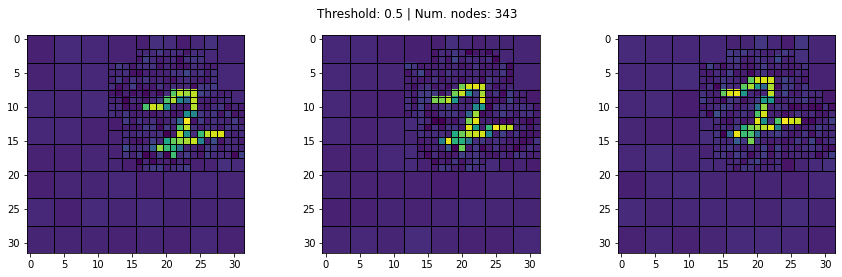

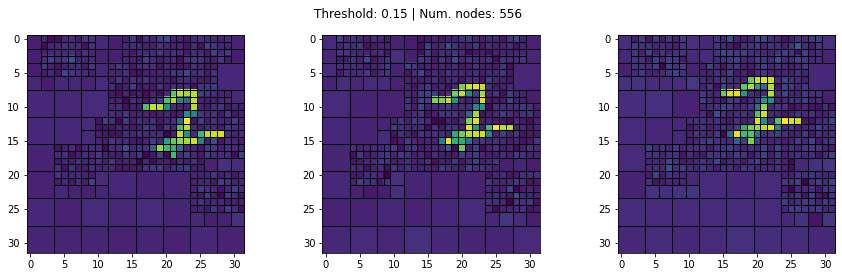

In [59]:
frame_index = 0

fig, axs = model.test_threshold(x, thresh=1.5, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.85, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.5, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.15, frame_index=frame_index)
plt.show()

In [60]:
# model.set_thresh(-np.inf)
# model.set_thresh(-2)
model.set_thresh(0.5)

model.train(x, y, x_test, y_test, lr=0.09, n_epochs=20)

KeyboardInterrupt: 

In [53]:
y_hat = model.predict(x_val)
print(torch.nn.BCELoss()(torch.Tensor(y_hat), torch.Tensor(y_val)))

tensor(0.0590)


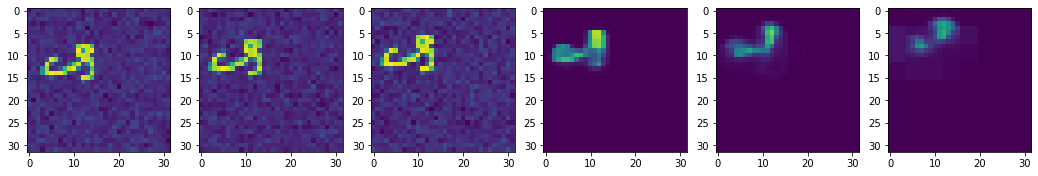

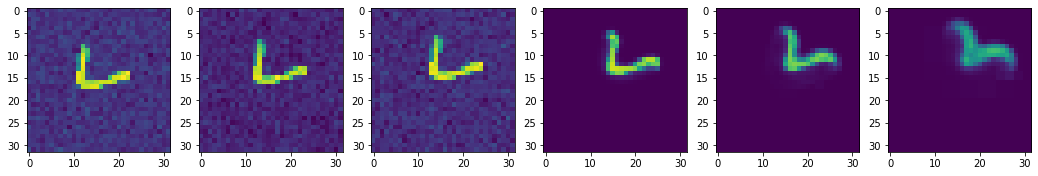

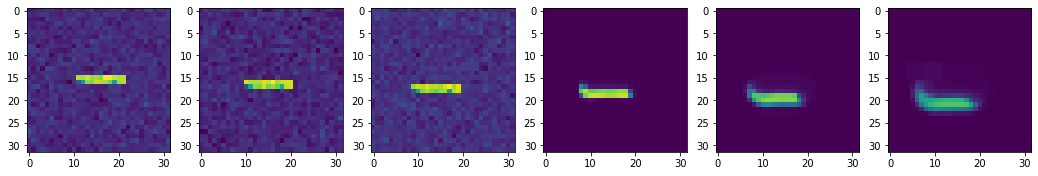

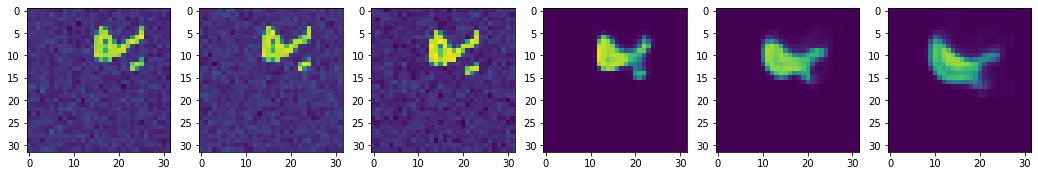

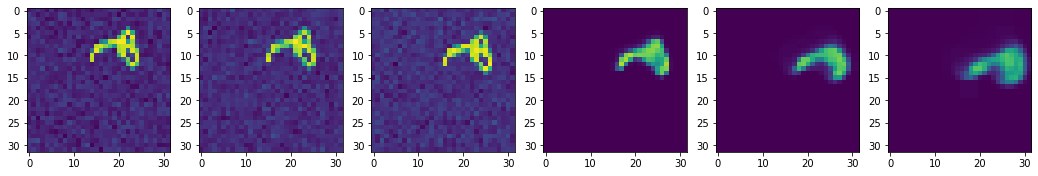

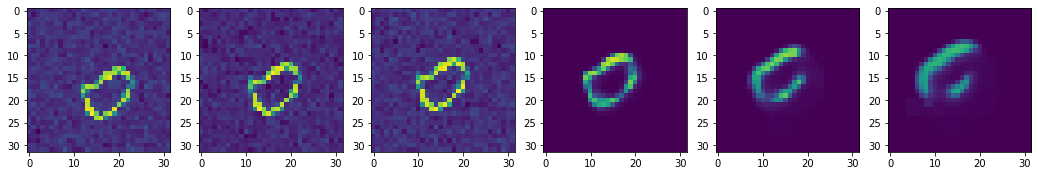

In [54]:
# Plot some example 
num_frames = 6

y_hat = model.predict(x_val[:num_frames])

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(x_val[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][..., 0], vmin=0, vmax=1)  # Prediction

<AxesSubplot: >

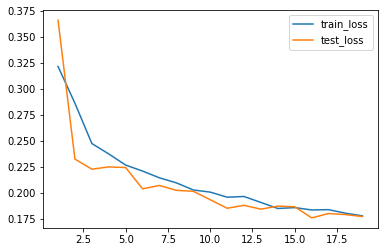

In [55]:
model.loss.iloc[1:].plot()